In [1]:
# plot composites (MEAN over all storms)
#
# below, the following can be plotted: 
#
# Fig 4 in paper (day of passing; totChl, totChl_emulator, totChl_hr)
# Fig 10 in paper (day of passing + delayed; totChl, MLD, integrated NPP)
# Fig S1 in paper (day of passing; totChl_emulator gap-filled clim vs full-field clim)
# Fig S6 in paper (day of passing; diatom & SP Fe and light limitation)
# Fig S6 in paper (day of passing; diatom & SP Fe and light limitation)
# Fig S8 in paper (day of passing + delayed; wind speed, incoming PAR)
# Fig S9 in paper (day of passing + delayed; MLD_hr, totChl_hr)
#
# original script: plot_CESM_composites_v2_GENERIC_corr_strongest_storms_v2_composites_FIXED_DUPLICATES.ipynb 
#   (This one also plots the median)


In [2]:
import os
from tqdm import tqdm
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from netCDF4 import Dataset, MFDataset
import numba as nb
import time as timing
from numba import njit 
from math import sin, cos, sqrt, atan2, radians
from geopy.distance import distance
import seawater as sw
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter,
                                LatitudeLocator)

In [3]:
#---
# CHOOSE YEARS to plot
#---

years = np.arange(1997,2018+1,1) 

#---
# SAVEPATH
#---

#---
# where to save plots?
#---
savepath_aux     = '/global/cfs/cdirs/m4003/cnissen/Plots/CESM_storms/composites_1997_2018_subtract_clim_first/'+\
                    'composites_FIXED_DUPLICATES/'
# check existence of paths
if not os.path.exists(savepath_aux):
    print ('Created '+savepath_aux)
    os.makedirs(savepath_aux)
    
dpicnt = 150
save_plots    = True
display_plots = True


In [4]:
#---
# FUNCTION 
#---

def get_distance_to_storm_center(lat2,lon2,aux_lat,aux_lon):
                
    # create list of locations within 1000km of the storm
    points_data = []
    for pp in range(0,lat2.shape[0]):
        aux = (lat2[pp],lon2[pp])
        points_data.append(aux)
        del aux

    #print(len(points_data))
    # for each of these points get the distance to the storm center in km -> get distance in x-dir and y-dir
    points_distance_x = np.zeros(len(points_data)) # distance in longitudinal direction, i.e., use latitude of storm (aux_lat)
    points_distance_y = np.zeros(len(points_data)) # distance in latitudinal direction, i.e., use longitude of storm (aux_lon)
    for pp in range(0,len(points_data)): 
        # distance in longitudinal direction
        aux_point = (aux_lat,points_data[pp][1])
        points_distance_x[pp] = distance(point_storm, aux_point).km
       # print(aux_point,point_storm,points_distance_x[pp])
        # check sign: if lon grid cell is smaller (=further west) than lon of storm, define distance to be negative
        if points_data[pp][1]<aux_lon:
            points_distance_x[pp] = -1*points_distance_x[pp]
        elif (aux_lon<0) & (points_data[pp][1]>0): # lon_storm is east of dateline, but grid cell is west of dateline (grid cell is also further west in this case!)
            if (points_data[pp][1]-360)<aux_lon:
                points_distance_x[pp] = -1*points_distance_x[pp]
        del aux_point
        # distance in latitudinal direction
        aux_point = (points_data[pp][0],aux_lon)
        points_distance_y[pp] = distance(point_storm, aux_point).km
        # check sign: if lat grid cell is smaller (=further south) than lat of storm, define distance to be negative
        if points_data[pp][0]<aux_lat:
            points_distance_y[pp] = -1*points_distance_y[pp]
        del aux_point  
    return points_distance_x,points_distance_y,points_data
                    
    
def bin_points_as_distance_to_storm_center(counter,points_distance_x,points_distance_y,x_bins,y_bins,aux_data_anom,data_storm_mean,data_storm_std,data_storm_count):
    # data_storm_mean,data_storm_std,data_storm_count: initialized arrays, will be filled in this function and then returned
    
    # bin the points (account for where each point is relative to storm center)
    ind_x = np.digitize(points_distance_x,x_bins,right=False) # minimum is 1 (not zero!!)
    ind_y = np.digitize(points_distance_y,y_bins,right=False)
 #   print(np.min(ind_x),np.max(ind_x))
 #   print(np.min(ind_y),np.max(ind_y))
    # returned index satisfies: bins[i-1] <= x < bins[i]

   # print(aux_data_anom.shape)
    for xx in range(1,len(x_bins)+1): # start at 1 here -> see note above for ind_x
        for yy in range(1,len(x_bins)+1):
            index = np.where((ind_y==yy) & (ind_x==xx))[0]
            if len(index)>0:
                #if counter==6: 
                #    print(xx,yy,index.shape,aux_data_anom.shape)
                #if (counter==40) & (xx==11) & (yy==20):
                #    print(xx,yy,len(points_distance_x))
                #    print(index)
                #    print(index.shape,aux_data_anom.shape)
                # anomaly 2
                data_storm_mean[xx-1,yy-1]  = np.nanmean(aux_data_anom[index])
                data_storm_std[xx-1,yy-1]   = np.nanstd(aux_data_anom[index])
                data_storm_count[xx-1,yy-1] = index.shape[0]
            del index
    return data_storm_mean,data_storm_std,data_storm_count
    
def get_median_ratio(data_storm_aux,data_dev_aux,month_storm_aux,ratio_median,ratio_median_monthly):
    
    # get the median ratio for each year
    counter = 0
    for ss in range(0,data_storm_aux.shape[0]):
        aux_field = 100*(np.nanmean(data_storm_aux[ss,:,:])/np.nanmean(data_dev_aux[ss,:,:]))
        if not np.isnan(aux_field):
            ratio_median[yy] = ratio_median[yy] + aux_field
            counter = counter+1
    ratio_median[yy] = np.divide(ratio_median[yy],counter)
    
    # get the median ratio for each year, EACH MONTH
    for mm in range(0,12):
        ind_mm = np.where(month_storm_aux==mm+1)[0]
        counter = 0
        for ss in ind_mm: 
            aux_field = 100*(np.nanmean(data_storm_aux[ss,:,:])/np.nanmean(data_dev_aux[ss,:,:]))
            if not np.isnan(aux_field):
                ratio_median_monthly[yy,mm] = ratio_median_monthly[yy,mm] + aux_field
                counter = counter+1
        ratio_median_monthly[yy,mm] = np.divide(ratio_median_monthly[yy,mm],counter)
        
    return ratio_median,ratio_median_monthly

def grow_arrays(yy,data_storm_aux,month_storm_aux,lat_storm_aux,lon_storm_aux,slp_avg_storm_aux,slp_min_storm_aux,\
                        data_storm,month_storm,lat_storm,lon_storm,slp_avg_storm,slp_min_storm): 
    if yy==0:
        data_storm  = data_storm_aux
        month_storm = month_storm_aux
        lat_storm   = lat_storm_aux
        lon_storm   = lon_storm_aux
        slp_min_storm   = slp_min_storm_aux
        slp_avg_storm   = slp_avg_storm_aux
    else:
        data_storm  = np.concatenate((data_storm,data_storm_aux))
        month_storm = np.concatenate((month_storm,month_storm_aux))
        lat_storm   = np.concatenate((lat_storm,lat_storm_aux))
        lon_storm   = np.concatenate((lon_storm,lon_storm_aux))
        slp_min_storm   = np.concatenate((slp_min_storm,slp_min_storm_aux))
        slp_avg_storm   = np.concatenate((slp_avg_storm,slp_avg_storm_aux))
                
    return data_storm,month_storm,lat_storm,lon_storm,slp_avg_storm,slp_min_storm

def load_data(path1a,file1,vari1a): 
    # storm-induced anomaly
    ff  = xr.open_dataset(path1a+file1)
    data_storm_aux  = ff[vari1a].values 
    month_storm_aux = ff['month_storm'].values  # at min. SLP
    lat_storm_aux   = ff['lat_storm'].values  # at min. SLP
    lon_storm_aux   = ff['lon_storm'].values  # at min. SLP
    slp_avg_storm_aux   = ff['avg_min_slp_storm'].values  # avg of all min SLP over all time steps of the storm's existence 
    slp_min_storm_aux   = ff['min_min_slp_storm'].values  # min. SLP over all time steps of the storm's existence 
    ff.close()
    data_storm_aux[data_storm_aux==0] = np.nan
    
    return data_storm_aux,month_storm_aux,lat_storm_aux,lon_storm_aux,slp_avg_storm_aux,slp_min_storm_aux



-------
Plot  diat_light_lim_surf 
-------

Created /global/cfs/cdirs/m4003/cnissen/Plots/CESM_storms/composites_1997_2018_subtract_clim_first/composites_FIXED_DUPLICATES/diat_light_lim_surf_TEST_gap_filling_emulator/
Created /global/cfs/cdirs/m4003/cnissen/Plots/CESM_storms/composites_1997_2018_subtract_clim_first/composites_FIXED_DUPLICATES/diat_light_lim_surf_TEST_gap_filling_emulator/eps/


/tmp/ipykernel_318810/3293273149.py:196: RuntimeWarning: Mean of empty slice
  data_aux_mean = np.nanmean(np.nanmean(data_aux,axis=2),axis=1)
/tmp/ipykernel_318810/3293273149.py:532: RuntimeWarning: Mean of empty slice
  data_aux_mean = np.nanmean(np.nanmean(data_aux,axis=2),axis=1)
/tmp/ipykernel_318810/3293273149.py:562: RuntimeWarning: Mean of empty slice
  data0 = np.nanmean(np.nanmean(data_aux_mean_lr_all,axis=2),axis=1)
/tmp/ipykernel_318810/3293273149.py:563: RuntimeWarning: Mean of empty slice
  data1 = np.nanmean(np.nanmean(data_aux_mean_lr1,axis=2),axis=1)
/tmp/ipykernel_318810/3293273149.py:564: RuntimeWarning: Mean of empty slice
  data2 = np.nanmean(np.nanmean(data_aux_mean_lr2,axis=2),axis=1)
/tmp/ipykernel_318810/3293273149.py:692: RuntimeWarning: invalid value encountered in true_divide
  data_count_all_rel_pos[mm,:,:] = 100*data_count_all/np.nansum(data_count_max2[ind_storm2])
/tmp/ipykernel_318810/3293273149.py:687: RuntimeWarning: invalid value encountered in true_di


#####

data_aux_mean_lr_all.shape (9554, 21, 21)
data_storms_0.shape (21, 21)
MEAN of all storms LOW RES, full, avg: -0.0023219069
STD of all storms, LOW RES, full, avg: 0.008242392
MIN of all storms, LOW RES, full, avg: -0.02253297
MAX of all storms, LOW RES, full, avg: 0.017273417
#####



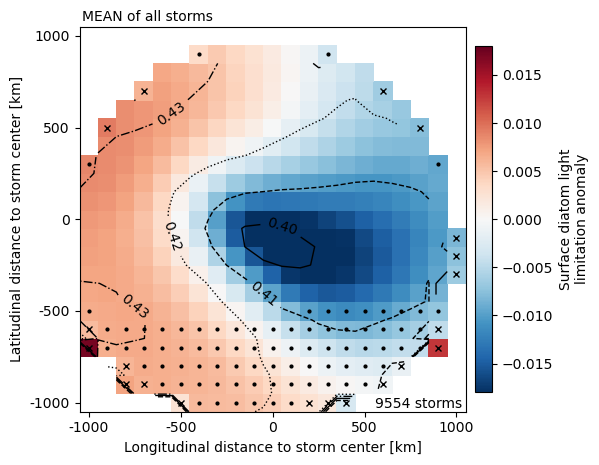

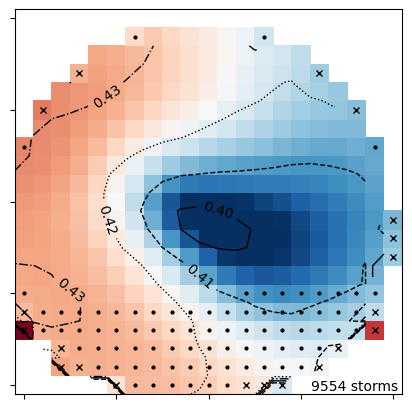

/tmp/ipykernel_318810/3293273149.py:509: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.ax.set_yticklabels(['']*len(cticks))


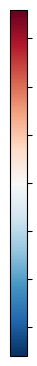


-------
Plot  sp_light_lim_surf 
-------

Created /global/cfs/cdirs/m4003/cnissen/Plots/CESM_storms/composites_1997_2018_subtract_clim_first/composites_FIXED_DUPLICATES/sp_light_lim_surf_TEST_gap_filling_emulator/
Created /global/cfs/cdirs/m4003/cnissen/Plots/CESM_storms/composites_1997_2018_subtract_clim_first/composites_FIXED_DUPLICATES/sp_light_lim_surf_TEST_gap_filling_emulator/eps/

#####

data_aux_mean_lr_all.shape (9554, 21, 21)
data_storms_0.shape (21, 21)
MEAN of all storms LOW RES, full, avg: -0.0034223665
STD of all storms, LOW RES, full, avg: 0.011783379
MIN of all storms, LOW RES, full, avg: -0.032083265
MAX of all storms, LOW RES, full, avg: 0.022906197
#####



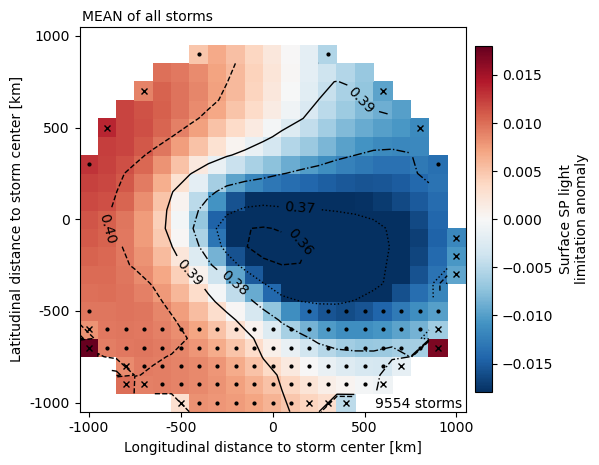

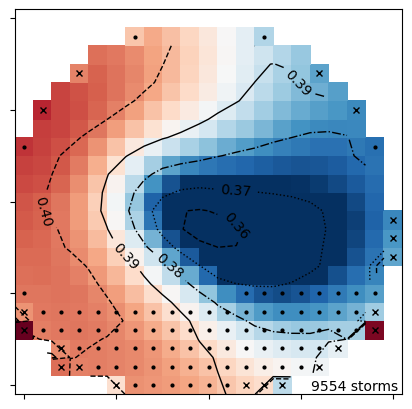

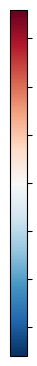


-------
Plot  diat_Fe_lim_surf 
-------

Created /global/cfs/cdirs/m4003/cnissen/Plots/CESM_storms/composites_1997_2018_subtract_clim_first/composites_FIXED_DUPLICATES/diat_Fe_lim_surf_TEST_gap_filling_emulator/
Created /global/cfs/cdirs/m4003/cnissen/Plots/CESM_storms/composites_1997_2018_subtract_clim_first/composites_FIXED_DUPLICATES/diat_Fe_lim_surf_TEST_gap_filling_emulator/eps/

#####

data_aux_mean_lr_all.shape (9554, 21, 21)
data_storms_0.shape (21, 21)
MEAN of all storms LOW RES, full, avg: 0.00010723897
STD of all storms, LOW RES, full, avg: 0.0015935766
MIN of all storms, LOW RES, full, avg: -0.0020210322
MAX of all storms, LOW RES, full, avg: 0.007762352
#####



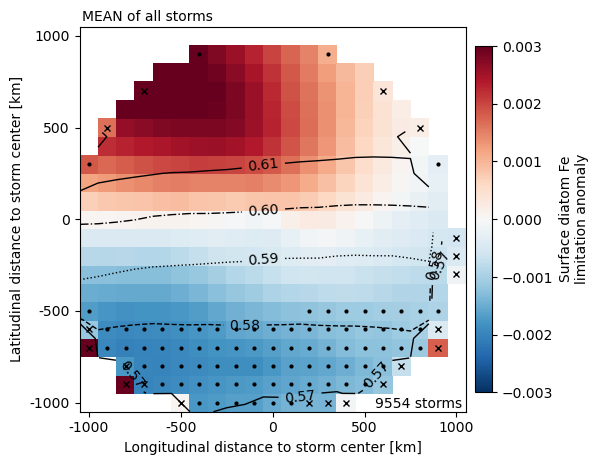

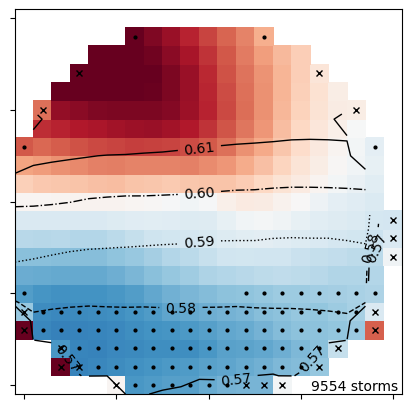

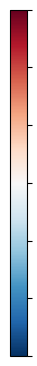


-------
Plot  sp_Fe_lim_surf 
-------

Created /global/cfs/cdirs/m4003/cnissen/Plots/CESM_storms/composites_1997_2018_subtract_clim_first/composites_FIXED_DUPLICATES/sp_Fe_lim_surf_TEST_gap_filling_emulator/
Created /global/cfs/cdirs/m4003/cnissen/Plots/CESM_storms/composites_1997_2018_subtract_clim_first/composites_FIXED_DUPLICATES/sp_Fe_lim_surf_TEST_gap_filling_emulator/eps/

#####

data_aux_mean_lr_all.shape (9554, 21, 21)
data_storms_0.shape (21, 21)
MEAN of all storms LOW RES, full, avg: 9.43335e-05
STD of all storms, LOW RES, full, avg: 0.001382457
MIN of all storms, LOW RES, full, avg: -0.0018028045
MAX of all storms, LOW RES, full, avg: 0.0075499765
#####



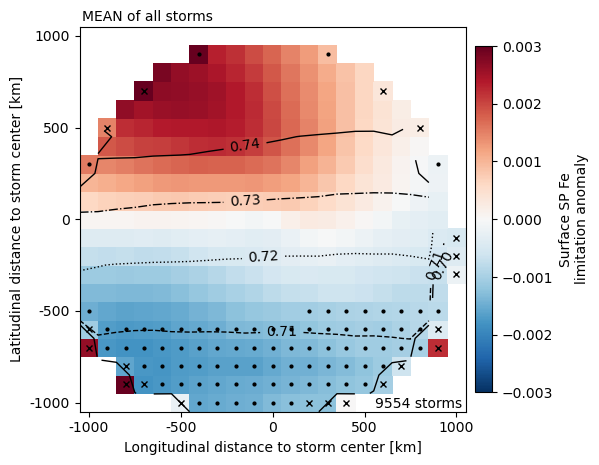

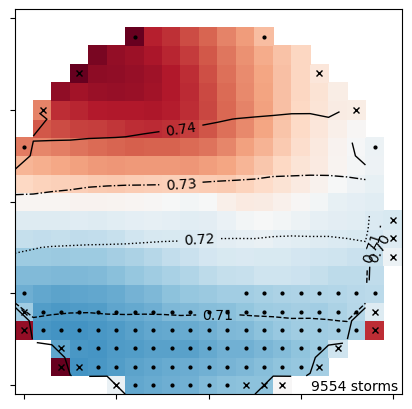

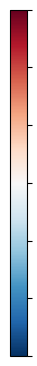

done  


In [15]:
#---
# LOAD COMPOSITES for totChl (low res/full, low res/emulator, high res)
#---

year_list = np.arange(1997,2018+1,1)

save_plots    = False
display_plots = True    
display_plots_aux = True # emulator, HR
display_plots_monthly = False

plot_emulator_hr = True # for some time_strings, these are not yet available!
full_field_clim_for_em = True 
# if True, use full field clim for emulator (as done in main part of paper); set to False for suppl. plots
        
plot_extremes = False # option to plot the 10% most extremes (Note: In the paper, I plot these for individual months! 
# Colorbar is not optimized when plotting these for all months in this script)


#-----
# DEFINE VARIABLE LIST: choose one of below (note: time_string_list and vari_list must be identical in length)

# Fig. 10
#vari_list = ['totChl','totChl','totChl',\
#            'MLD','MLD','MLD',\
#            'photoC_zint','photoC_zint','photoC_zint']
#time_string_list = ['','_plus_2_days','_plus_4_days',\
#                   '','_plus_2_days','_plus_4_days',\
#                   '','_plus_2_days','_plus_4_days']

# Fig. S1 (set plot_emulator_hr = True, full_field_clim_for_em=False)
#vari_list = ['totChl']
#time_string_list = ['']

# Fig. S6
vari_list = ['diat_light_lim_surf','sp_light_lim_surf','diat_Fe_lim_surf','sp_Fe_lim_surf']
time_string_list = ['','','','']

## Fig. S8
#vari_list = ['wind_speed','wind_speed','wind_speed',\
#            'PAR_incoming','PAR_incoming','PAR_incoming']
#time_string_list = ['','_plus_2_days','_plus_4_days',\
#                   '','_plus_2_days','_plus_4_days']

## Fig. S9
#vari_list = ['MLD_hr','MLD_hr','MLD_hr']
#time_string_list = ['','_plus_2_days','_plus_4_days']

# Fig. 4 and totChl_hr in Fig. S9 (set plot_emulator_hr = True)
#vari_list = ['totChl','totChl','totChl']
#time_string_list = ['','_plus_2_days','_plus_4_days']

#-----

   
perc1 = 10 #25
perc2 = 90 #75

for vv in range(0,len(vari_list)):
    vari = vari_list[vv]
    time_string = time_string_list[vv]
    print()
    print('-------')
    print('Plot ',vari,time_string)
    print('-------')
    print()

    # where are data
    path1 = '/global/cfs/cdirs/m4003/cnissen/CESM_anomalies_STORM_PAPER_subtract_clim_first/'+vari+'_anomalies/'
    path2 = '/global/cfs/cdirs/m4003/cnissen/CESM_anomalies_STORM_PAPER_subtract_clim_first/'+vari+'_emulator_anomalies/TEST/'
    path3 = '/global/cfs/cdirs/m4003/cnissen/CESM_anomalies_STORM_PAPER_subtract_clim_first/'+vari+'_hr_anomalies/'

    # if vari is not totChl, provide path to totChl (LOW RES, full & emulator) here --> files need to be loaded so that strongest storms can be identified correctly
    path_chl    = '/global/cfs/cdirs/m4003/cnissen/CESM_anomalies_STORM_PAPER_subtract_clim_first/totChl_anomalies/'
    path_chl_em = '/global/cfs/cdirs/m4003/cnissen/CESM_anomalies_STORM_PAPER_subtract_clim_first/totChl_emulator_anomalies/'

    if time_string=='':
        savepath = savepath_aux+vari+'_TEST_gap_filling_emulator/'
    else:
        savepath = savepath_aux+vari+'/'+time_string+'_v2/'
    # check existence of paths
    if not os.path.exists(savepath):
        print ('Created '+savepath)
        os.makedirs(savepath)
    savepath2 = savepath+'eps/'
    if not os.path.exists(savepath2):
        print ('Created '+savepath2)
        os.makedirs(savepath2)

    #----
    # LOW RES, FULL FIELD
    #----

    # storm-induced anomaly
    file1 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_'+vari+'_'+\
                str(year_list[0])+'_'+str(year_list[-1])+time_string+'_subtract_clim_first.nc'
    file1b = 'Composite_abs_field_within_1000km_of_storm_center_at_noon_'+vari+'_'+\
                str(year_list[0])+'_'+str(year_list[-1])+time_string+'_subtract_clim_first.nc'

    # load data
    data_storm,month_storm,lat_storm,\
                lon_storm,slp_avg_storm,slp_min_storm = load_data(path1,file1,vari+'_storm_anomaly4_mean')

    #---
    # ABS
    #---
    # load data
    data_storm_abs,month_storm_abs,lat_storm_abs,\
                lon_storm_abs,slp_avg_storm_abs,slp_min_storm_abs = load_data(path1,file1b,vari+'_storm_mean')

        
    # if I chose a different variable above, load totChl of LOW RES anyway (full + emulator)
    #   (for determining storms with strongest impact)
    #
    # NOTE: always load data on day of storm passing here! This is the basis for determining the strongest storms.
    #
    if (not vari=='totChl') | (not time_string==''): 
        #----
        # LOW RES, FULL FIELD, anomalies only (only needed to determine strongest storms)
        #----

        # storm-induced anomaly
        file1 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_totChl_'+\
                    str(year_list[0])+'_'+str(year_list[-1])+''+'_subtract_clim_first.nc'
        file1b = 'Composite_abs_field_within_1000km_of_storm_center_at_noon_'+vari+'_'+\
                    str(year_list[0])+'_'+str(year_list[-1])+''+'_subtract_clim_first.nc'

        # load data
        data_storm_chl,month_storm_chl,lat_storm_chl,\
                     lon_storm_chl,slp_avg_storm_chl,slp_min_storm_chl = load_data(path_chl,file1,'totChl_storm_anomaly4_mean')
        
    if (vari=='totChl') & plot_emulator_hr:
        #----
        # LOW RES, EMULATOR
        #----
        
        if full_field_clim_for_em:
            em_string  = ''
        else: # use emulator-based climatology (gap-filled)   
            em_string = '_gap_filled_clim'
        print('em_string',em_string)
        
        # storm-induced anomaly
        file1 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_totChl_emulator_'+\
                    str(year_list[0])+'_'+str(year_list[-1])+time_string+'_subtract_clim_first'+em_string+'.nc' #_full_field_clim
        file1b = 'Composite_abs_field_within_1000km_of_storm_center_at_noon_totChl_emulator_'+\
                str(year_list[0])+'_'+str(year_list[-1])+time_string+'_subtract_clim_first'+em_string+'.nc'

        # load data
        data_storm_em,month_storm_em,lat_storm_em,lon_storm_em,\
                    slp_avg_storm_em,slp_min_storm_em = load_data(path2,file1,vari+'_emulator_storm_anomaly4_mean')

        #----
        # HIGH RES, FULL FIELD
        #----

        # storm-induced anomaly
        file1 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_totChl_hr_'+\
                    str(year_list[0])+'_'+str(year_list[-1])+time_string+'_subtract_clim_first.nc'
        file1b = 'Composite_abs_field_within_1000km_of_storm_center_at_noon_totChl_hr_'+\
                    str(year_list[0])+'_'+str(year_list[-1])+time_string+'_subtract_clim_first.nc'

        # load data
        data_storm_hr,month_storm_hr,lat_storm_hr,lon_storm_hr,\
                slp_avg_storm_hr,slp_min_storm_hr = load_data(path3,file1,vari+'_storm_anomaly4_mean')

        #---
        # ABS
        #---
        # load data
        data_storm_hr_abs,month_storm_hr_abs,lat_storm_hr_abs,\
                    lon_storm_hr_abs,slp_avg_storm_hr_abs,slp_min_storm_hr_abs = load_data(path3,file1b,vari+'_storm_mean')

            

 #   print('data_storm.shape',data_storm.shape)
 #   if (vari=='totChl') & plot_emulator_hr:
 #       print('data_storm_em.shape',data_storm_em.shape)
 #       print('data_storm_hr.shape',data_storm_hr.shape)
 #   if (not vari=='totChl') | (not time_string==''): 
 #       print('data_storm_chl.shape',data_storm_chl.shape)

    #---
    # only consider storms that have data in LOW RES full (correct arrays here)
    #---
  #  print()
  #  print('Only consider storms with data in LOW RES full in analysis...')

    # what is the array called that contains totChl (LOW RES full)?
    if time_string=='':
        if vari=='totChl':
            data_aux    = np.copy(data_storm)
        else:
            data_aux    = np.copy(data_storm_chl)
    else: # if BEFORE/AFTER is chosen, always use "chl on day of storm passing" here (--> basis for selction of strong storms)
        data_aux    = np.copy(data_storm_chl)

    # find storms of interest based on chl anomalies
    data_aux_mean = np.nanmean(np.nanmean(data_aux,axis=2),axis=1)
    ind_no_NaN = np.where(~np.isnan(data_aux_mean))[0]

 #   print('BEFORE kicking out NaNs: data_storm.shape',data_storm.shape)
    if time_string=='_plus_4_days': # last storm does not exist in data
        data_storm  = data_storm[ind_no_NaN[:-1],:,:]
        month_storm = month_storm[ind_no_NaN[:-1]]
        lat_storm   = lat_storm[ind_no_NaN[:-1]]
        lon_storm   = lon_storm[ind_no_NaN[:-1]]
        slp_avg_storm = slp_avg_storm[ind_no_NaN[:-1]]
        slp_min_storm = slp_min_storm[ind_no_NaN[:-1]]
        data_storm_abs = data_storm_abs[ind_no_NaN[:-1],:,:]
    elif time_string=='_plus_6_days': # last storms do not exist in data
        data_storm  = data_storm[ind_no_NaN[:-5],:,:]
        month_storm = month_storm[ind_no_NaN[:-5]]
        lat_storm   = lat_storm[ind_no_NaN[:-5]]
        lon_storm   = lon_storm[ind_no_NaN[:-5]]
        slp_avg_storm = slp_avg_storm[ind_no_NaN[:-5]]
        slp_min_storm = slp_min_storm[ind_no_NaN[:-5]]
        data_storm_abs = data_storm_abs[ind_no_NaN[:-5],:,:]
    else:
        data_storm  = data_storm[ind_no_NaN,:,:]
        month_storm = month_storm[ind_no_NaN]
        lat_storm   = lat_storm[ind_no_NaN]
        lon_storm   = lon_storm[ind_no_NaN]
        slp_avg_storm = slp_avg_storm[ind_no_NaN]
        slp_min_storm = slp_min_storm[ind_no_NaN]
        data_storm_abs = data_storm_abs[ind_no_NaN,:,:]
 #   print('AFTER kicking out NaNs: data_storm.shape',data_storm.shape)
 #   print('AFTER kicking out NaNs: data_storm_abs.shape',data_storm_abs.shape)
    if (not vari=='totChl') | (not time_string==''): 
        data_storm_chl  = data_storm_chl[ind_no_NaN,:,:]
 #       print('AFTER kicking out NaNs: data_storm_chl.shape',data_storm_chl.shape)

    # emulator & HR: only consider storms that have data in LOW RES full
    if (vari=='totChl') & plot_emulator_hr:
        if time_string=='_plus_4_days':
            data_storm_em     = data_storm_em[ind_no_NaN[:-1],:,:]
            data_storm_hr     = data_storm_hr[ind_no_NaN[:-1],:,:]
            data_storm_hr_abs = data_storm_hr_abs[ind_no_NaN[:-1],:,:]
        else:
            data_storm_em     = data_storm_em[ind_no_NaN,:,:]
            data_storm_hr     = data_storm_hr[ind_no_NaN,:,:]
            data_storm_hr_abs = data_storm_hr_abs[ind_no_NaN,:,:]
 #       print('AFTER kicking out NaNs: data_storm_em.shape',data_storm_em.shape)
 #       print('AFTER kicking out NaNs: data_storm_hr.shape',data_storm_hr.shape)
 #       print('AFTER kicking out NaNs: data_storm_hr_abs.shape',data_storm_hr_abs.shape)
        
    #---
    # settings for plotting
    #---

    months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

    if vari=='totChl':
        v1,v2   = -0.1,0.1 # MEAN
        v1b,v2b = -0.03,0.03 # MEDIAN
        contours_abs = [0.2,0.22,0.24,0.26] #[0.05,0.1,0.2,0.4,0.6,0.8,1]
        factor  = 1
        cbar_label = 'Surface chlorophyll\nanomaly in mg m$^{-3}$'
    elif vari=='MLD':
        v1,v2   = -6,6 # MEAN
        v1b,v2b = -5,5 # MEDIAN
        contours_abs = [108,112,116,120] #[40,60,80,100,120,140,160]
        factor  = 0.01 # convert from cm to m
        cbar_label = 'MLD\nanomaly in m'
    elif vari=='MLD_hr':
        v1,v2   = -6,6 # MEAN
        v1b,v2b = -5,5 # MEDIAN
        contours_abs = [92,96,100,104,108] #[40,60,80,100,120,140,160]
        factor  = 0.01 # convert from cm to m
        cbar_label = 'MLD\nanomaly in m'
    elif vari=='PAR_incoming':
        v1,v2   = -10,10 #-20,20 # MEAN
        v1b,v2b = -10,10 #-20,20 # MEDIAN
        contours_abs = [40,60,80,100,120,140,160]
        factor  = 1
        cbar_label = 'Incoming PAR\nanomaly in W m$^{-2}$'
    elif vari=='wind_speed':
        v1,v2   = -4,4 # MEAN
        v1b,v2b = -4,4 # MEDIAN
        contours_abs = [4,6,8,10,12,14]
        factor  = 1
        cbar_label = 'Wind speed\nanomaly in m s$^{-1}$'
    elif vari=='mu_diat':
        v1,v2   = -0.05,0.05 # MEAN
        v1b,v2b = -0.03,0.03  # MEDIAN
        contours_abs = [0.1,0.2,0.3,0.4,0.5,0.6]
        factor  = 1
        cbar_label = 'Diatom growth rate\nanomaly in d$^{-1}$'
    elif vari=='mu_sp':
        v1,v2   = -0.05,0.05 # MEAN
        v1b,v2b = -0.03,0.03  # MEDIAN
        contours_abs = [0.1,0.2,0.3,0.4,0.5,0.6]
        factor     = 1
        cbar_label = 'SP growth rate\nanomaly in d$^{-1}$'
    elif vari=='phytoC_zint_100m':
        v1,v2   = -1,1 # MEAN
        v1b,v2b = -1,1  # MEDIAN
        contours_abs = [1,5,10,15]
        factor       = 0.001 # convert from mmol to mol
        cbar_label   = 'Integrated phytoC biomass\nanomaly in mol C m$^{-2}$'
    elif vari=='photoC_total_surf':
        v1,v2   = -0.002,0.002
        v1b,v2b = -0.002,0.002
        factor  = 86400*0.01 # convert from mmol m-3 cm s-1  to  mmol m-2 d-1
        contours_abs = [0.001,0.007,0.01,0.015]
        cbar_label   = 'Surface NPP\nanomaly in mmol m$^{-2}$ d$^{-1}$'
    elif vari=='photoC_zint':
        v1,v2   = -2,2 #-5,5
        v1b,v2b = -5,5
        factor = 86400*0.01 # convert from mmol m-3 cm s-1  to  mmol m-2 d-1
        contours_abs = [12,15,18,21] #[20,30,40]
        cbar_label  = 'Vertically integrated NPP\nanomaly in mmol m$^{-2}$ d$^{-1}$'
    elif vari=='slp':
        v1,v2   = -15,15
        v1b,v2b = -15,15
        factor = 0.01 # convert from Pa to hPa
        contours_abs = [945,955,965,975,985,995,1005] #[20,30,40]
        cbar_label  = 'Sea lvel pressure\nanomaly in hPa'
    elif vari=='diat_Fe_lim_surf':
        v1,v2   = -0.003,0.003
        v1b,v2b = -0.003,0.003
        factor = 1
        contours_abs = [0.57,0.58,0.59,0.6,0.61]
        cbar_label   = 'Surface diatom Fe\nlimitation anomaly'
    elif vari=='sp_Fe_lim_surf':
        v1,v2   = -0.003,0.003
        v1b,v2b = -0.003,0.003
        factor = 1
        contours_abs = [0.7,0.71,0.72,0.73,0.74]
        cbar_label   = 'Surface SP Fe\nlimitation anomaly'
    elif vari=='diat_light_lim_surf':
        v1,v2   = -0.018,0.018
        v1b,v2b = -0.018,0.018
        factor = 1
        contours_abs = [0.4,0.41,0.42,0.43,0.44,0.45] #0.57,0.58,0.59,0.6,0.61]
        cbar_label   = 'Surface diatom light\nlimitation anomaly'
    elif vari=='sp_light_lim_surf':
        v1,v2   = -0.018,0.018
        v1b,v2b = -0.018,0.018
        factor = 1
        contours_abs = [0.35,0.36,0.37,0.38,0.39,0.40] #0.57,0.58,0.59,0.6,0.61]
        cbar_label   = 'Surface SP light\nlimitation anomaly'
             
    # for strongest storms, adjust limits
    if (perc1==10) & (perc2==90): 
        if vari=='totChl':
            v1,v2   = v1,v2 #0.25*v1,0.25*v2 #2*v1,2*v2
            v1b,v2b = v1,v2
        else:
            if vari=='slp':
                v1,v2   = v1,v2
                v1b,v2b = v1b,v2b
            elif vari=='diat_Fe_lim_surf':
                v1,v2   = v1,v2
                v1b,v2b = v1b,v2b
            elif vari=='sp_Fe_lim_surf':
                v1,v2   = v1,v2
                v1b,v2b = v1b,v2b
            elif vari=='diat_light_lim_surf':
                v1,v2   = v1,v2
                v1b,v2b = v1b,v2b
            elif vari=='sp_light_lim_surf':
                v1,v2   = v1,v2
                v1b,v2b = v1b,v2b
            elif vari=='wind_speed':
                v1,v2   = v1,v2
                v1b,v2b = v1b,v2b
            elif vari=='MLD':
                v1,v2   = v1,v2
                v1b,v2b = v1b,v2b
            elif vari=='PAR_incoming':
                v1,v2   = v1,v2
                v1b,v2b = v1b,v2b
            else:
                v1,v2   = 2*v1,2*v2
                v1b,v2b = 2*v1b,2*v2b

    def plot_composite(data_plot,data_plot_abs,data_stippling,thrsh_list,v1,v2,contours_abs,\
                       cbar_label,num_storms,label_string,time_string,save_plots,display_plots,savepath,filename):

        cmap1  = plt.cm.RdBu_r
        fs     = 10
        dpicnt = 150
        lw = 1
        if contours_abs[0]<1:
            if contours_abs[0]<0.1:
                format_labels = "%1.3f"
            else:
                format_labels = "%1.2f"
        else:
            format_labels = "%d"

        res    = 100
        x_bins = np.arange(-1000,1000+res,res)
        y_bins = np.arange(-1000,1000+res,res)
        xticks = np.arange(0,len(x_bins))
        xticks = [(x+0.5) for x in xticks]

        plot_abs = False
        if plot_abs:
            fig = plt.figure(figsize=(6,5))
            plt.pcolor(data_plot_abs.transpose(),cmap=plt.cm.RdYlBu_r,vmin=0,vmax=0.4)
            plt.colorbar()
            plt.show()

        add_stippling = True

    #    # plot abs
    #    fig = plt.figure(figsize=(6,5))
    #    plt.pcolor(data_plot_abs.transpose(),cmap=cmap1)
    #    plt.colorbar()
    #    plt.show()
        
        fig = plt.figure(figsize=(6,5))
        m1=plt.pcolor(data_plot.transpose(),cmap=cmap1,vmin=v1,vmax=v2)
        cbar=plt.colorbar(m1,orientation='vertical',shrink=0.9,pad=0.02)#,ticks=cticks)
        cbar.set_label(cbar_label,fontsize=fs)
        cbar.ax.tick_params(labelsize=fs)
        # GET CURRENT TICKS ON COLORBAR
        cticks = cbar.ax.get_yticklabels()
        plt.xticks(xticks[0::5],x_bins[0::5])
        plt.yticks(xticks[0::5],y_bins[0::5])
        plt.ylabel('Latitudinal distance to storm center [km]',fontsize=fs)
        plt.xlabel('Longitudinal distance to storm center [km]',fontsize=fs)
        plt.annotate(label_string,xy=(0.005,1.015),xycoords='axes fraction',fontsize=fs,ha='left') 
        plt.annotate(str(num_storms)+' storms',xy=(0.99,0.01),xycoords='axes fraction',fontsize=fs,ha='right') 
        CS=plt.contour(data_plot_abs.transpose(),levels=contours_abs,colors=['k','k','k','k','k','k','k'],\
                    linewidths=[lw,lw,lw,lw,lw,lw,lw],linestyles=['-','--',':','-.','-','--',':'])
        try:
            CS.clabel(contours_abs, inline=1, fmt=format_labels, fontsize=10)
        except:
            pass

        if add_stippling:
            #data_stippling = np.copy(data_count_all_rel)[mm,:,:]
            # add stippling for locations with value below XX%
            threshold1 = thrsh_list[0] #25
            for xx in range(0,len(xticks)):
                for yy in range(0,len(xticks)):
                    if data_stippling.transpose()[xx,yy]<=threshold1:
                        plt.plot(yy+0.5,xx+0.5,'kx',markersize=4)
                        #plt.plot(yy+0.5,xx+0.5,'ko',markerfacecolor='none',markersize=4,linewidth=1)
            threshold2 = thrsh_list[1] #40
            for xx in range(0,len(xticks)):
                for yy in range(0,len(xticks)):
                    if (data_stippling.transpose()[xx,yy]<=threshold2) & (data_stippling.transpose()[xx,yy]>threshold1):
                        plt.plot(yy+0.5,xx+0.5,'k.',markerfacecolor='k',markersize=4,linewidth=1)
                        #plt.plot(yy+0.5,xx+0.5,'k.',markersize=1)
        if time_string in ['_plus_1_days','_plus_2_days','_plus_3_days','_plus_4_days','_plus_4_days']:
            plt.annotate('+'+time_string[6]+' days',xy=(0.99,0.96),xycoords='axes fraction',fontsize=fs,ha='right') 
        elif time_string in ['_minus_1_days','_minus_2_days','_minus_3_days']:
            plt.annotate('-'+time_string[7]+' days',xy=(0.99,0.96),xycoords='axes fraction',fontsize=fs,ha='right') 
        if save_plots:
            plt.savefig(savepath+filename,dpi = dpicnt, bbox_inches='tight')
        if display_plots:
            plt.show()
        else:
            plt.close(fig)
            
            
        plot_eps = True
        if plot_eps:
            fig = plt.figure(figsize=(5,5))
            m1=plt.pcolor(data_plot.transpose(),cmap=cmap1,vmin=v1,vmax=v2)
            #cbar=plt.colorbar(m1,orientation='vertical',shrink=0.9,pad=0.02)#,ticks=cticks)
            #cbar.set_label(cbar_label,fontsize=fs)
            #cbar.ax.tick_params(labelsize=fs)
            plt.xticks(xticks[0::5],[])
            plt.yticks(xticks[0::5],[])
            #plt.annotate(label_string,xy=(0.005,1.015),xycoords='axes fraction',fontsize=fs,ha='left') 
            plt.annotate(str(num_storms)+' storms',xy=(0.99,0.01),xycoords='axes fraction',fontsize=fs,ha='right') 
            CS=plt.contour(data_plot_abs.transpose(),levels=contours_abs,colors=['k','k','k','k','k','k','k'],\
                        linewidths=[lw,lw,lw,lw,lw,lw,lw],linestyles=['-','--',':','-.','-','--',':'])
            try:
                CS.clabel(contours_abs, inline=1, fmt=format_labels, fontsize=10)
            except:
                pass

            if add_stippling:
                #data_stippling = np.copy(data_count_all_rel)[mm,:,:]
                # add stippling for locations with value below XX%
                threshold1 = thrsh_list[0] #25
                for xx in range(0,len(xticks)):
                    for yy in range(0,len(xticks)):
                        if data_stippling.transpose()[xx,yy]<=threshold1:
                            plt.plot(yy+0.5,xx+0.5,'kx',markersize=4)
                            #plt.plot(yy+0.5,xx+0.5,'ko',markerfacecolor='none',markersize=4,linewidth=1)
                threshold2 = thrsh_list[1] #40
                for xx in range(0,len(xticks)):
                    for yy in range(0,len(xticks)):
                        if (data_stippling.transpose()[xx,yy]<=threshold2) & (data_stippling.transpose()[xx,yy]>threshold1):
                            plt.plot(yy+0.5,xx+0.5,'k.',markerfacecolor='k',markersize=4,linewidth=1)
                            #plt.plot(yy+0.5,xx+0.5,'k.',markersize=1)
            if time_string in ['_plus_1_days','_plus_2_days','_plus_3_days','_plus_4_days']:
                plt.annotate('+'+time_string[6]+' days',xy=(0.99,0.96),xycoords='axes fraction',fontsize=fs,ha='right') 
            elif time_string in ['_minus_1_days','_minus_2_days','_minus_3_days']:
                plt.annotate('-'+time_string[7]+' days',xy=(0.99,0.96),xycoords='axes fraction',fontsize=fs,ha='right') 
            if save_plots:
                plt.savefig(savepath+'eps/'+filename[:-4]+'.eps',dpi = dpicnt, bbox_inches='tight',format='eps')
            if display_plots:
                plt.show()
            else:
                plt.close(fig)
                
            # COLORBAR ONLY
            fig = plt.figure(figsize=(6,5))
            m1=plt.pcolor(data_plot.transpose(),cmap=plt.cm.RdBu_r,vmin=v1,vmax=v2)
            plt.gca().set_visible(False)
            cbar=plt.colorbar(m1,orientation='vertical',shrink=0.9,pad=0.02)#,ticks=cticks)
            #cbar.set_label(cbar_label,fontsize=fs)
            cbar.ax.tick_params(labelsize=fs)
            cbar.ax.set_yticklabels(['']*len(cticks))
            if save_plots:
                plt.savefig(savepath+'eps/'+filename[:-4]+'_colorbar.eps',dpi = dpicnt, bbox_inches='tight',format='eps')
            if display_plots:
                plt.show()
            else:
                plt.close(fig)
    
       
    #----
    # identify the strongest storms based on LOW RES full field
    #----

    # what is the array called that contains totChl  to used here (LOW RES full, day of passing)?
    if time_string=='':
        if vari=='totChl':
            data_aux    = np.copy(data_storm)
        else:
            data_aux    = np.copy(data_storm_chl)
    else:
        data_aux = np.copy(data_storm_chl)

    # determine thresholds for "strong" storms based on LOW RES full field
    data_aux_mean = np.nanmean(np.nanmean(data_aux,axis=2),axis=1)
    ind_no_NaN = np.where(~np.isnan(data_aux_mean))[0]
    thrsh1 = np.percentile(data_aux_mean[ind_no_NaN],perc1) # XX% with largest negative anomaly
    thrsh2 = np.percentile(data_aux_mean[ind_no_NaN],perc2) # XX% with largest positive anomaly
    ind_strong1_lr = np.where(data_aux_mean[ind_no_NaN]<=thrsh1)[0]
    ind_strong2_lr = np.where(data_aux_mean[ind_no_NaN]>=thrsh2)[0]

    # create arrays to plot for LR, emulator & HR
    if time_string=='_plus_4_days': # last storm does not exist in data
        data_aux_mean_lr_all = data_storm[ind_no_NaN[:-1],:,:]
        data_aux_mean_lr1    = data_storm[ind_no_NaN[:-1],:,:][ind_strong1_lr,:,:]
        data_aux_mean_lr2    = data_storm[ind_no_NaN[:-1],:,:][ind_strong2_lr[:-1],:,:]
        data_aux_mean_lr_all_abs = data_storm_abs[ind_no_NaN[:-1],:,:]
        data_aux_mean_lr1_abs    = data_storm_abs[ind_no_NaN[:-1],:,:][ind_strong1_lr,:,:]
        data_aux_mean_lr2_abs    = data_storm_abs[ind_no_NaN[:-1],:,:][ind_strong2_lr[:-1],:,:]
    elif time_string=='_plus_6_days': # last storm does not exist in data
        data_aux_mean_lr_all = data_storm[ind_no_NaN[:-5],:,:]
        data_aux_mean_lr1    = data_storm[ind_no_NaN[:-5],:,:][ind_strong1_lr,:,:]
        data_aux_mean_lr2    = data_storm[ind_no_NaN[:-5],:,:][ind_strong2_lr[:-5],:,:]
        data_aux_mean_lr_all_abs = data_storm_abs[ind_no_NaN[:-5],:,:]
        data_aux_mean_lr1_abs    = data_storm_abs[ind_no_NaN[:-5],:,:][ind_strong1_lr,:,:]
        data_aux_mean_lr2_abs    = data_storm_abs[ind_no_NaN[:-5],:,:][ind_strong2_lr[:-5],:,:]
    else:
        data_aux_mean_lr_all = data_storm[ind_no_NaN,:,:]
        data_aux_mean_lr1    = data_storm[ind_no_NaN,:,:][ind_strong1_lr,:,:]
        data_aux_mean_lr2    = data_storm[ind_no_NaN,:,:][ind_strong2_lr,:,:]
        data_aux_mean_lr_all_abs = data_storm_abs[ind_no_NaN,:,:]
        data_aux_mean_lr1_abs    = data_storm_abs[ind_no_NaN,:,:][ind_strong1_lr,:,:]
        data_aux_mean_lr2_abs    = data_storm_abs[ind_no_NaN,:,:][ind_strong2_lr,:,:]
    # How many of the remaining storms have data?
    data0 = np.nanmean(np.nanmean(data_aux_mean_lr_all,axis=2),axis=1)
    data1 = np.nanmean(np.nanmean(data_aux_mean_lr1,axis=2),axis=1)
    data2 = np.nanmean(np.nanmean(data_aux_mean_lr2,axis=2),axis=1)
    ind_no_NaN0 = np.where(~np.isnan(data0))[0]
    ind_no_NaN1 = np.where(~np.isnan(data1))[0]
    ind_no_NaN2 = np.where(~np.isnan(data2))[0]
    num_storms_lr  = ind_no_NaN0.shape[0]
    num_storms_lr1 = ind_no_NaN1.shape[0]
    num_storms_lr2 = ind_no_NaN2.shape[0]
    del data0,data1,data2,ind_no_NaN0,ind_no_NaN1,ind_no_NaN2

    if (vari=='totChl') & plot_emulator_hr:
        if time_string=='_plus_4_days':
            data_aux_mean_em_all = data_storm_em[ind_no_NaN[:-1],:,:]
            data_aux_mean_em1    = data_storm_em[ind_no_NaN[:-1],:,:][ind_strong1_lr,:,:]
            data_aux_mean_em2    = data_storm_em[ind_no_NaN[:-1],:,:][ind_strong2_lr[:-1],:,:]
            data_aux_mean_em_all_abs = data_storm_abs[ind_no_NaN[:-1],:,:] #--- USE FULL FIELD ABSOLUTE HERE! -----#
            data_aux_mean_em1_abs    = data_storm_abs[ind_no_NaN[:-1],:,:][ind_strong1_lr,:,:]
            data_aux_mean_em2_abs    = data_storm_abs[ind_no_NaN[:-1],:,:][ind_strong2_lr[:-1],:,:]
        else:
            data_aux_mean_em_all = data_storm_em[ind_no_NaN,:,:]
            data_aux_mean_em1    = data_storm_em[ind_no_NaN,:,:][ind_strong1_lr,:,:]
            data_aux_mean_em2    = data_storm_em[ind_no_NaN,:,:][ind_strong2_lr,:,:]
            data_aux_mean_em_all_abs = data_storm_abs[ind_no_NaN,:,:] #--- USE FULL FIELD ABSOLUTE HERE! -----#
            data_aux_mean_em1_abs    = data_storm_abs[ind_no_NaN,:,:][ind_strong1_lr,:,:]
            data_aux_mean_em2_abs    = data_storm_abs[ind_no_NaN,:,:][ind_strong2_lr,:,:]
        # How many of the remaining storms have data?
        data0 = np.nanmean(np.nanmean(data_aux_mean_em_all,axis=2),axis=1)
        data1 = np.nanmean(np.nanmean(data_aux_mean_em1,axis=2),axis=1)
        data2 = np.nanmean(np.nanmean(data_aux_mean_em2,axis=2),axis=1)
        ind_no_NaN0 = np.where(~np.isnan(data0))[0]
        ind_no_NaN1 = np.where(~np.isnan(data1))[0]
        ind_no_NaN2 = np.where(~np.isnan(data2))[0]
        num_storms_em  = ind_no_NaN0.shape[0]
        num_storms_em1 = ind_no_NaN1.shape[0]
        num_storms_em2 = ind_no_NaN2.shape[0]
        del data0,data1,data2,ind_no_NaN0,ind_no_NaN1,ind_no_NaN2

        if time_string=='_plus_4_days':
            data_aux_mean_hr_all = data_storm_hr[ind_no_NaN[:-1],:,:]
            data_aux_mean_hr1    = data_storm_hr[ind_no_NaN[:-1],:,:][ind_strong1_lr,:,:]
            data_aux_mean_hr2    = data_storm_hr[ind_no_NaN[:-1],:,:][ind_strong2_lr[:-1],:,:]
            data_aux_mean_hr_all_abs = data_storm_hr_abs[ind_no_NaN[:-1],:,:]
            data_aux_mean_hr1_abs    = data_storm_hr_abs[ind_no_NaN[:-1],:,:][ind_strong1_lr,:,:]
            data_aux_mean_hr2_abs    = data_storm_hr_abs[ind_no_NaN[:-1],:,:][ind_strong2_lr[:-1],:,:]
        else:
            data_aux_mean_hr_all = data_storm_hr[ind_no_NaN,:,:]
            data_aux_mean_hr1    = data_storm_hr[ind_no_NaN,:,:][ind_strong1_lr,:,:]
            data_aux_mean_hr2    = data_storm_hr[ind_no_NaN,:,:][ind_strong2_lr,:,:]
            data_aux_mean_hr_all_abs = data_storm_hr_abs[ind_no_NaN,:,:]
            data_aux_mean_hr1_abs    = data_storm_hr_abs[ind_no_NaN,:,:][ind_strong1_lr,:,:]
            data_aux_mean_hr2_abs    = data_storm_hr_abs[ind_no_NaN,:,:][ind_strong2_lr,:,:]
        # How many of the remaining storms have data?
        data0 = np.nanmean(np.nanmean(data_aux_mean_hr_all,axis=2),axis=1)
        data1 = np.nanmean(np.nanmean(data_aux_mean_hr1,axis=2),axis=1)
        data2 = np.nanmean(np.nanmean(data_aux_mean_hr2,axis=2),axis=1)
        ind_no_NaN0 = np.where(~np.isnan(data0))[0]
        ind_no_NaN1 = np.where(~np.isnan(data1))[0]
        ind_no_NaN2 = np.where(~np.isnan(data2))[0]
        num_storms_hr  = ind_no_NaN0.shape[0]
        num_storms_hr1 = ind_no_NaN1.shape[0]
        num_storms_hr2 = ind_no_NaN2.shape[0]
        del data0,data1,data2,ind_no_NaN0,ind_no_NaN1,ind_no_NaN2

        
    #---
    # load num_obs data for full field to add stippling to anomaly plots
    #---

    dist_threshold = 1000

    path1 = '/global/cfs/cdirs/m4003/cnissen/CESM_anomalies_STORM_PAPER_subtract_clim_first/count_obs_in_anomalies/'

    def load_data_for_stippling(path1,name_string,vari,years,dist_threshold,ind_no_NaN,ind_strong1_lr,ind_strong2_lr,month_storm):

        if vari=='totChl_hr':
            file1 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_hr_'+str(years[0])+'_'+str(years[-1])+\
                    '_subtract_clim_first_COUNT_OBS.nc'
        elif vari=='totChl_emulator':
            file1 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_emulator_'+str(years[0])+'_'+str(years[-1])+\
                    '_subtract_clim_first_full_field_clim_COUNT_OBS.nc'
        else:
            file1 = 'Composite_anomalies_within_1000km_of_storm_center_at_noon_'+str(years[0])+'_'+str(years[-1])+\
                    '_subtract_clim_first_COUNT_OBS.nc'
        
        # anomaly of vari
        ff  = xr.open_dataset(path1+file1)
        data_count      = ff[vari+'_storm_anomaly4_count'].values 
        data_count_max  = ff[vari+'_storm_anomaly4_count_max'].values 
        month_storm     = ff['month_storm'].values  # at min. SLP
        days_storm      = ff['days_storm'].values 
        lon_storm       = ff['lon_storm'].values # at min. SLP
        lat_storm       = ff['lat_storm'].values # at min. SLP
        min_slp         = ff['min_min_slp_storm'].values # Minimum sea level pressure during the existence of each storm (based on min. SLP at noon)
        ff.close()

        # only consider storms with data in LOW RES full field
        data_count1    = data_count[ind_no_NaN,:,:][ind_strong1_lr,:,:]
        data_count2    = data_count[ind_no_NaN,:,:][ind_strong2_lr,:,:]
        data_count_max1    = data_count_max[ind_no_NaN][ind_strong1_lr]
        data_count_max2    = data_count_max[ind_no_NaN][ind_strong2_lr]
        month_storm1    = month_storm[ind_no_NaN][ind_strong1_lr]
        month_storm2    = month_storm[ind_no_NaN][ind_strong2_lr]
        
        #---
        # get monthly stippling information
        #---

        data_count_all_rel     = np.nan*np.ones([12,21,21])
        data_count_all_rel_pos = np.nan*np.ones([12,21,21])
        data_count_all_rel_neg = np.nan*np.ones([12,21,21])
        for mm in range(0,12):

            # find storms of interest
            ind_storm        = np.where(month_storm==mm+1)[0]
            ind_storm1       = np.where(month_storm1==mm+1)[0]
            ind_storm2       = np.where(month_storm2==mm+1)[0]

            # all storms
            data_count_all             = np.nansum(data_count[ind_storm],axis=0)
            data_count_all_rel[mm,:,:] = 100*data_count_all/np.nansum(data_count_max[ind_storm])
            del data_count_all

            # strongest storms with neg. chl anomaly
            data_count_all                 = np.nansum(data_count1[ind_storm1],axis=0)
            data_count_all_rel_neg[mm,:,:] = 100*data_count_all/np.nansum(data_count_max1[ind_storm1])
            del data_count_all

            # strongest storms with pos. chl anomaly
            data_count_all                 = np.nansum(data_count2[ind_storm2],axis=0)
            data_count_all_rel_pos[mm,:,:] = 100*data_count_all/np.nansum(data_count_max2[ind_storm2])
            del data_count_all

        data_count_all_rel[data_count_all_rel==0] = np.nan
        data_count_all_rel_pos[data_count_all_rel_pos==0] = np.nan
        data_count_all_rel_neg[data_count_all_rel_neg==0] = np.nan

 #       print(data_count_all_rel.shape,np.nanmin(data_count_all_rel),np.nanmax(data_count_all_rel))
 #       print(data_count_all_rel_pos.shape,np.nanmin(data_count_all_rel_pos),np.nanmax(data_count_all_rel_pos))
 #       print(data_count_all_rel_neg.shape,np.nanmin(data_count_all_rel_neg),np.nanmax(data_count_all_rel_neg))

        return data_count_all_rel,data_count_all_rel_pos,data_count_all_rel_neg


    # LOW RES, full field
    name_string = ''
    vari_obs = 'totChl'
    data_count_all_rel,data_count_all_rel_pos,data_count_all_rel_neg = load_data_for_stippling(path1,name_string,vari_obs,\
                                        years,dist_threshold,ind_no_NaN,ind_strong1_lr,ind_strong2_lr,month_storm)

    if (vari=='totChl') & plot_emulator_hr:
        # LOW RES, emulator
        name_string = 'emulator_'
        vari_obs = 'totChl_emulator'
        data_count_all_rel_em,data_count_all_rel_pos_em,data_count_all_rel_neg_em = load_data_for_stippling(path1,name_string,vari_obs,\
                                            years,dist_threshold,ind_no_NaN,ind_strong1_lr,ind_strong2_lr,month_storm)

        # HIGH RES
        name_string = 'hr_'
        vari_obs = 'totChl_hr'
        data_count_all_rel_hr,data_count_all_rel_pos_hr,data_count_all_rel_neg_hr = load_data_for_stippling(path1,name_string,vari_obs,\
                                            years,dist_threshold,ind_no_NaN,ind_strong1_lr,ind_strong2_lr,month_storm)

    test_plot = False
    if test_plot:
        fig = plt.figure(figsize=(6,5))
        plt.pcolor(np.nanmean(data_count_all_rel,axis=0).transpose())
        plt.colorbar()
        plt.contour(np.nanmean(data_count_all_rel,axis=0).transpose(),levels=[25,40])
        plt.show()


        
    #---
    # MEAN/MEDIAN & STRONGEST STORMS (all months together)
    #---
    #
    # NOTE: for full fields, only include storms that are also included in emulator!!! Else I am not comparing the same things!
    #       I.e., irrespective of what variable is chosen, I always need to load LOW RES full field & emulator to select the correct storms!
    #
        
    # MEAN of all storms
    data_storms_0 = np.nanmean(data_aux_mean_lr_all,axis=0) # ALL
    data_storms_1 = np.nanmean(data_aux_mean_lr1,axis=0) # strongest negative anomaly
    data_storms_2 = np.nanmean(data_aux_mean_lr2,axis=0) # strongest positive anomaly
    data_storms_0_abs = np.nanmean(data_aux_mean_lr_all_abs,axis=0) # ALL
    data_storms_1_abs = np.nanmean(data_aux_mean_lr1_abs,axis=0) # strongest negative anomaly
    data_storms_2_abs = np.nanmean(data_aux_mean_lr2_abs,axis=0) # strongest positive anomaly

    # data stippling
    data_stippling = np.nanmean(data_count_all_rel,axis=0)
    data_stippling_pos = np.nanmean(data_count_all_rel_pos,axis=0)
    data_stippling_neg = np.nanmean(data_count_all_rel_neg,axis=0)
    thrsh_list = [25,40]
    
    # all storms
    if vari in ['slp','wind_speed','PAR_incoming','diat_Fe_lim_surf','sp_Fe_lim_surf',\
               'diat_light_lim_surf','sp_light_lim_surf','MLD']:
        f4 = 1
    elif vari in ['totChl']:
        f4 = 0.3
    else:
        f4 = 0.5         

        
    # strongest
    if vari in ['totChl','slp','wind_speed']:
        f5 = 1
    elif vari in ['PAR_incoming']:
        f5 = 2
    elif vari in ['MLD']:
        f5 = 2
    else:
        f5 = 2

    # MEAN of all storms
    print()
    print('#####')
    print(time_string)
    print('data_aux_mean_lr_all.shape',data_aux_mean_lr_all.shape)
    print('data_storms_0.shape',data_storms_0.shape)
    print('MEAN of all storms LOW RES, full, avg:',np.nanmean(factor*data_storms_0))
    print('STD of all storms, LOW RES, full, avg:',np.nanstd(factor*data_storms_0))
    print('MIN of all storms, LOW RES, full, avg:',np.nanmin(factor*data_storms_0))
    print('MAX of all storms, LOW RES, full, avg:',np.nanmax(factor*data_storms_0))
    print('#####')
    print()
    
    filename = 'Composite'+time_string+'_'+str(year_list[0])+'_'+str(year_list[-1])+'_'+vari+'_LOW_RES_full_all_storms_MEAN_all_months.png'
    plot_composite(factor*data_storms_0,factor*data_storms_0_abs,data_stippling,thrsh_list,\
                   f4*v1,f4*v2,contours_abs,cbar_label,num_storms_lr,'MEAN of all storms',\
                   time_string,save_plots,display_plots,savepath,filename) # ALL

    if plot_extremes:
        filename = 'Composite'+time_string+'_'+str(year_list[0])+'_'+str(year_list[-1])+'_'+vari+'_LOW_RES_full_'+str(perc1)+'perc_storms_strongest_neg_totChl_anomaly_MEAN_all_months.png'
        plot_composite(factor*data_storms_1,factor*data_storms_1_abs,data_stippling_neg,thrsh_list,\
                       f5*v1,f5*v2,contours_abs,cbar_label,num_storms_lr1,'MEAN of the '+str(perc1)+'% storms with the strongest negative totChl anomaly',\
                       time_string,save_plots,display_plots,savepath,filename) # strongest negative anomaly

        filename = 'Composite'+time_string+'_'+str(year_list[0])+'_'+str(year_list[-1])+'_'+vari+'_LOW_RES_full_'+str(100-perc2)+'perc_storms_strongest_pos_totChl_anomaly_MEAN_all_months.png'
        plot_composite(factor*data_storms_2,factor*data_storms_2_abs,data_stippling_pos,thrsh_list,\
                       f5*v1,f5*v2,contours_abs,cbar_label,num_storms_lr2,'MEAN of the '+str(100-perc2)+'% storms with the strongest positive totChl anomaly',\
                       time_string,save_plots,display_plots,savepath,filename) # strongest positive anomaly

    if vari=='PAR_incoming':
        f3 = 1 #0.25
    elif vari=='wind_speed':
        f3 = 1 #0.25
    elif vari=='mu_diat':
        f3 = 1
    elif vari=='mu_sp':
        f3 = 1
    elif vari=='photoC_total_surf':
        f3 = 1
    elif vari=='photoC_zint':
        f3 = 0.5
    elif vari=='phytoC_zint_100m':
        f3 = 1
    elif vari=='totChl':
        f3 = 1
    elif vari=='slp':
        f3 = 1
    elif vari=='sp_Fe_lim_surf':
        f3 = 1
    elif vari=='diat_Fe_lim_surf':
        f3 = 1
    elif vari=='sp_light_lim_surf':
        f3 = 1
    elif vari=='diat_light_lim_surf':
        f3 = 1
    elif vari=='MLD':
        f3 = 1
    else:
        f3 = 0.5

    del data_storms_0,data_storms_1,data_storms_2,data_storms_0_abs,data_storms_1_abs,data_storms_2_abs
   
    
    #---
    # if vari is totChl, plot emulator
    #---

    if (vari=='totChl') & plot_emulator_hr:

        #---
        # EMULATOR
        #---
        print('emulator...')
        print('data_aux_mean_em_all.shape',data_aux_mean_em_all.shape)
        # MEAN of all storms
        data_storms_0 = np.nanmean(data_aux_mean_em_all,axis=0) # ALL
        data_storms_1 = np.nanmean(data_aux_mean_em1,axis=0) # strongest negative anomaly
        data_storms_2 = np.nanmean(data_aux_mean_em2,axis=0) # strongest positive anomaly
        data_storms_0_abs = np.nanmean(data_aux_mean_em_all_abs,axis=0) # ALL
        data_storms_1_abs = np.nanmean(data_aux_mean_em1_abs,axis=0) # strongest negative anomaly
        data_storms_2_abs = np.nanmean(data_aux_mean_em2_abs,axis=0) # strongest positive anomaly
        
        # data stippling
        data_stippling = np.mean(data_count_all_rel_em,axis=0)
        data_stippling_pos = np.mean(data_count_all_rel_pos_em,axis=0)
        data_stippling_neg = np.mean(data_count_all_rel_neg_em,axis=0)
        thrsh_list = [0,0] # NO STIPPLING FOR EMULATOR (data coverage is low everywhere) #[25,40]

        # MEAN of all storms
        print('MEAN of all storms, LOW RES, emulator, avg:',np.nanmean(factor*data_storms_0))
        print('STD of all storms, LOW RES, emulator, avg:',np.nanstd(factor*data_storms_0))
        print('MIN of all storms, LOW RES, emulator, avg:',np.nanmin(factor*data_storms_0))
        print('MAX of all storms, LOW RES, emulator, avg:',np.nanmax(factor*data_storms_0))
        
        filename = 'Composite'+time_string+'_'+str(year_list[0])+'_'+str(year_list[-1])+'_'+vari+'_LOW_RES_emulator_all_storms_MEAN_all_months'+em_string+'.png'
        plot_composite(factor*data_storms_0,factor*data_storms_0_abs,data_stippling,thrsh_list,\
                   f4*v1,f4*v2,contours_abs,cbar_label,num_storms_em,'MEAN of all storms',\
                   time_string,save_plots,display_plots_aux,savepath,filename) # ALL

        if plot_extremes:
            filename = 'Composite'+time_string+'_'+str(year_list[0])+'_'+str(year_list[-1])+'_'+vari+'_LOW_RES_emulator_'+str(perc1)+'perc_storms_strongest_neg_totChl_anomaly_MEAN_all_months'+em_string+'.png'
            plot_composite(factor*data_storms_1,factor*data_storms_1_abs,data_stippling_neg,thrsh_list,\
                       f5*v1,f5*v2,contours_abs,cbar_label,num_storms_em1,'MEAN of the '+str(perc1)+'% storms with the strongest negative totChl anomaly',\
                       time_string,save_plots,display_plots_aux,savepath,filename) # strongest negative anomaly

            filename = 'Composite'+time_string+'_'+str(year_list[0])+'_'+str(year_list[-1])+'_'+vari+'_LOW_RES_emulator_'+str(100-perc2)+'perc_storms_strongest_pos_totChl_anomaly_MEAN_all_months'+em_string+'.png'
            plot_composite(factor*data_storms_2,factor*data_storms_2_abs,data_stippling_pos,thrsh_list,\
                       f5*v1,f5*v2,contours_abs,cbar_label,num_storms_em2,'MEAN of the '+str(100-perc2)+'% storms with the strongest positive totChl anomaly',\
                       time_string,save_plots,display_plots_aux,savepath,filename) # strongest positive anomaly

        del data_storms_0,data_storms_1,data_storms_2,data_storms_0_abs,data_storms_1_abs,data_storms_2_abs
        

    #---
    # if vari is totChl, plot HR
    #---

    if (vari=='totChl') & plot_emulator_hr:

        #---
        # HIGH RES
        #---
        print('HIGH RES...')
        print('data_aux_mean_hr_all.shape',data_aux_mean_hr_all.shape)
        # MEAN of all storms
        data_storms_0 = np.nanmean(data_aux_mean_hr_all,axis=0) # ALL
        data_storms_1 = np.nanmean(data_aux_mean_hr1,axis=0) # strongest negative anomaly
        data_storms_2 = np.nanmean(data_aux_mean_hr2,axis=0) # strongest positive anomaly
        data_storms_0_abs = np.nanmean(data_aux_mean_hr_all_abs,axis=0) # ALL
        data_storms_1_abs = np.nanmean(data_aux_mean_hr1_abs,axis=0) # strongest negative anomaly
        data_storms_2_abs = np.nanmean(data_aux_mean_hr2_abs,axis=0) # strongest positive anomaly
        
        contours_abs_hr = [2*x for x in contours_abs]

        # data stippling
        data_stippling = np.mean(data_count_all_rel_hr,axis=0)
        data_stippling_pos = np.mean(data_count_all_rel_pos_hr,axis=0)
        data_stippling_neg = np.mean(data_count_all_rel_neg_hr,axis=0)
        thrsh_list = [25,40]

        # MEAN of all storms
        print('MEAN of all storms, HIGH RES, full, avg:',np.nanmean(factor*data_storms_0))
        print('STD of all storms, HIGH RES, full, avg:',np.nanstd(factor*data_storms_0))
        print('MIN of all storms, HIGH RES, full, avg:',np.nanmin(factor*data_storms_0))
        print('MAX of all storms, HIGH RES, full, avg:',np.nanmax(factor*data_storms_0))
        filename = 'Composite'+time_string+'_'+str(year_list[0])+'_'+str(year_list[-1])+'_'+vari+'_HIGH_RES_full_all_storms_MEAN_all_months.png'
        plot_composite(factor*data_storms_0,factor*data_storms_0_abs,data_stippling,thrsh_list,\
                   f4*v1,f4*v2,contours_abs_hr,cbar_label,num_storms_hr,'MEAN of all storms',\
                   time_string,save_plots,display_plots_aux,savepath,filename) # ALL

        if plot_extremes:
            filename = 'Composite'+time_string+'_'+str(year_list[0])+'_'+str(year_list[-1])+'_'+vari+'_HIGH_RES_full_'+str(perc1)+'perc_storms_strongest_neg_totChl_anomaly_MEAN_all_months.png'
            plot_composite(factor*data_storms_1,factor*data_storms_1_abs,data_stippling_neg,thrsh_list,\
                       f5*v1,f5*v2,contours_abs_hr,cbar_label,num_storms_hr1,'MEAN of the '+str(perc1)+'% storms with the strongest negative totChl anomaly',\
                       time_string,save_plots,display_plots_aux,savepath,filename) # strongest negative anomaly

            filename = 'Composite'+time_string+'_'+str(year_list[0])+'_'+str(year_list[-1])+'_'+vari+'_HIGH_RES_full_'+str(100-perc2)+'perc_storms_strongest_pos_totChl_anomaly_MEAN_all_months.png'
            plot_composite(factor*data_storms_2,factor*data_storms_2_abs,data_stippling_pos,thrsh_list,\
                       f5*v1,f5*v2,contours_abs_hr,cbar_label,num_storms_hr2,'MEAN of the '+str(100-perc2)+'% storms with the strongest positive totChl anomaly',\
                       time_string,save_plots,display_plots_aux,savepath,filename) # strongest positive anomaly

        del data_storms_0,data_storms_1,data_storms_2,data_storms_0_abs,data_storms_1_abs,data_storms_2_abs

print('done ',time_string)
    
# thrsh1,thrsh2 -0.030338433757424354 0.02789403870701792
# thrsh1,thrsh2 -0.030338433757424354 0.02789403870701792

In [ ]:

#path1 = '/global/cfs/cdirs/m4003/cnissen/CESM_MLD_regridded/'
#file1 = 'MLD_JRA_grid_2000-01-01.nc'
#
#ff  = xr.open_dataset(path1+file1)
#lat = ff['latitude'].values   
#lon = ff['longitude'].values   
#ff.close()
#
#print(np.diff(lat))
#print(np.diff(lon))

